In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import cv2, os
import numpy as np
import keras
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import matplotlib.pyplot as plt
size=256
classes=5
image_dir='Test_Images/test_image_patches'
mask_dir='Test_Images/test_mask_patches'
data_shape = size*size
PSPnet_Prediction='data512/Predictions/PSPnet_Prediction/'
Unet_Prediction='data512/Predictions/Unet_Prediction/'
Segnet_Prediction='data512/Predictions/Segnet_Prediction/'
Groud_truth='data512/Predictions/Ground_truth/'

Using TensorFlow backend.
/home/aakashjuseja/anaconda3/envs/first-project/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
image_path = [os.path.join(image_dir, x) for x in sorted(os.listdir(image_dir)) if x.endswith('.png')]
mask_path = [os.path.join(mask_dir, x) for x in sorted(os.listdir(mask_dir)) if x.endswith('.png')]
image_path=np.array(image_path)
mask_path=np.array(mask_path)

In [3]:
test_set = []
mask_set=[]
for i in range(image_path.shape[0]):
    test_set.append(cv2.imread(image_path[i]))
    mask_set.append(cv2.imread(mask_path[i],0))

    #data.append(cv2.resize(cv2.imread(image_path[i]),(size,size)))
test_set=np.array(test_set)
test_set=test_set/255.0
mask_set=np.array(mask_set)

In [4]:
from keras import backend as K
def mean_iou(y_true, y_pred):
    import numpy as np
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 5)
        K.get_session().run(tf.local_variables_initializer())
    with tf.control_dependencies([up_opt]):
        score = tf.identity(score)
    prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [5]:
from keras import backend as K
def pix_acc(y_true, y_pred):
    intersetion=(y_true==y_pred)
    mean=np.mean(intersetion)
    return mean

In [6]:
model=[]
from keras.models import load_model
#model=load_model('data512/Unet_001.h5')
#model=load_model('data512/unet_001.h5',custom_objects={'mean_iou': mean_iou})
model=load_model('unet_001-42-0.56.h5')

In [7]:
#from keras.models import load_model
#model=load_model('data512/PSPnet_001.h5')

In [8]:
def hot_encoder(label):
    size=256
    mask = np.zeros((size, size, classes))
    for c in range(classes):
        mask[:,:,c] = (label==c).astype(int)
        
    return mask

In [9]:
mask_set2=[]
for i in range(mask_set.shape[0]):
    mask_set2.append(hot_encoder(mask_set[i]))
mask_set2=np.array(mask_set2)
print(mask_set2.shape)

(961, 256, 256, 5)


In [8]:
mask_set2=[]
for i in range(mask_set.shape[0]):
    mask_set2.append(np.reshape(hot_encoder(mask_set[i]),(size*size,5)))
mask_set2=np.array(mask_set2)
print(mask_set2.shape)

(961, 65536, 5)


In [11]:
model.evaluate(test_set,mask_set2,verbose=1)

961/961 [==============================] - 22s 23ms/step


[0.9228758517958991, 0.6579158120051135]

In [10]:
predictions=model.predict(test_set)

In [11]:
predictions=np.reshape(predictions,(predictions.shape[0],size,size,5))
print(predictions.shape)

(961, 256, 256, 5)


In [12]:
prediction_masks=np.zeros((predictions.shape[0],size,size))
#predictions=np.round(predictions)
for i in range(predictions.shape[0]):
    '''for j in range(5):
        #prediction_masks[i][:,:]=prediction_masks[i][:,:]+((j+1)*predictions[i][:,:,j])
        predictions[i][:,:,j]=((j+1)*predictions[i][:,:,j])'''
    prediction_masks[i][:,:]=np.argmax(predictions[i],axis=2)

In [13]:
acc_per_image=[]
for i in range(mask_set.shape[0]):
    acc_per_image.append(pix_acc(mask_set[i],prediction_masks[i]))
np.mean(acc_per_image)

0.6961159760696459

In [14]:
from PIL import Image
def write_image(image):
    '''
    Label data to colored image
    color pallets found at: http://www.discoveryplayground.com/computer-programming-for-kids/rgb-colors/
    '''
    White = [255, 255, 255]
    Water = [0, 255, 0]
    Background = [0, 0, 0]
    Building = [131, 139, 139]
    Green = [139, 69, 19]
    
    r = image.copy()
    g = image.copy()
    b = image.copy()
    
    label_colors = np.array([White, Water, Background, Building, Green])
    
    for label in range(0, 5):
        r[image==label] = label_colors[label, 0]
        g[image==label] = label_colors[label, 1]
        b[image==label] = label_colors[label, 2]
    rgb = np.zeros((image.shape[0], image.shape[1], 3))
    rgb[:,:,0] = r/1.0
    rgb[:,:,1] = g/1.0
    rgb[:,:,2] = b/1.0
    im = Image.fromarray(np.uint8(rgb))
    #im.save(filename)
    return im

In [ ]:
for i in range(10):
    print(i)
    plt.imshow(test_set[i])
    plt.show()
    plt.imshow((write_image(mask_set[i][:,:])))
    plt.show()
    plt.imshow(write_image(prediction_masks[i][:,:]))
    plt.show()


In [43]:
result=np.zeros((7936,7936))
j=0
size=256
for h in range(31):
    for w in range(31):
        # used to go through every image with same box size
        h_start = size * h
        h_end =   size + size * h
        w_start = size * w
        w_end =   size + size * w

        result[(h_start):(h_end), (w_start):(w_end)]=prediction_masks[j]
        j+=1


In [26]:
result2=np.zeros((7936,7936))
j=0
size=256
for h in range(31):
    for w in range(31):
        # used to go through every image with same box size
        h_start = size * h
        h_end =   size + size * h
        w_start = size * w
        w_end =   size + size * w

        result2[(h_start):(h_end), (w_start):(w_end)]=mask_set[j]
        j+=1

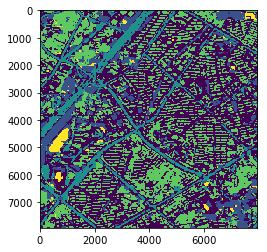

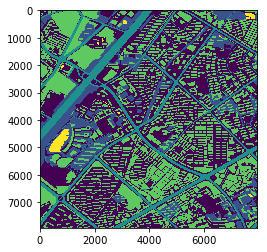

In [44]:
plt.imshow(result)
plt.show()
plt.imshow(result2)

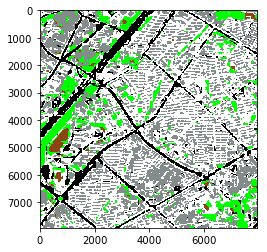

In [45]:
im=write_image(result)
plt.imshow(im)

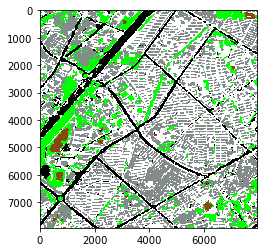

In [35]:
im=write_image(result)
plt.imshow(im)

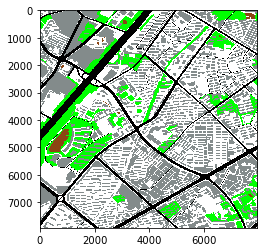

In [33]:
im=write_image(result2)
plt.imshow(im)

In [46]:
im.save('segnet_result.png')